In [313]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pymystem3 import Mystem
from stop_words import get_stop_words
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
import re
import string
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle

In [2]:
ads = pd.read_csv('/Users/admin/Documents/contextAdvertising1.csv')

In [3]:
ads.shape

(799999, 3)

In [4]:
ads.head()

,atitle,atext,adomain
0,Клуб активного отдыха «0.67»,Детский пейнтбол. Спортивный пейнтбол. Тактиче...,0-67.relax.by
1,Антигравитационный чехол IPhone 5,Успейте купить антигравитационный чехол для IP...,0-antigravity.ru
2,Антигравитационный чехол купить!,Антигравитационный чехол для телефона купить з...,0-antigravity.ru
3,Беспроцентный заем от Moneyveo,Без справок! Получите до 3 000 грн. на карту п...,0-credit.moneyveo.ua
4,Беспроцентный заем сотруднику,Акция! Получите Кредит Онлайн под 0%. Без Спра...,0-credit.moneyveo.ua


In [5]:
#check how many unique titles we have
ads['atitle'].nunique()

571923

In [6]:
#check how many unique ads texts we have
ads['atext'].nunique()

350006

In [7]:
(ads['atitle'] + ads['atext']).nunique()

792924

In [8]:
unique_adstext =ads.drop_duplicates(subset = ['atext'])

In [9]:
unique_adstext.nunique()

atitle     254397
atext      350006
adomain      5550
dtype: int64

In [10]:
#it appears that even after we remove duplicate ads texts, we still have duplicate titles 
unique_adstext['atitle'].nunique()

254397

In [11]:
unique =unique_adstext.drop_duplicates(subset = ['atitle'])

In [12]:
unique.nunique()

atitle     254397
atext      254396
adomain      5447
dtype: int64

In [13]:
unique.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 254397 entries, 0 to 772549
Data columns (total 3 columns):
atitle     254397 non-null object
atext      254396 non-null object
adomain    254397 non-null object
dtypes: object(3)
memory usage: 7.8+ MB


In [14]:
unique.head()

,atitle,atext,adomain
0,Клуб активного отдыха «0.67»,Детский пейнтбол. Спортивный пейнтбол. Тактиче...,0-67.relax.by
1,Антигравитационный чехол IPhone 5,Успейте купить антигравитационный чехол для IP...,0-antigravity.ru
2,Антигравитационный чехол купить!,Антигравитационный чехол для телефона купить з...,0-antigravity.ru
3,Беспроцентный заем от Moneyveo,Без справок! Получите до 3 000 грн. на карту п...,0-credit.moneyveo.ua
4,Беспроцентный заем сотруднику,Акция! Получите Кредит Онлайн под 0%. Без Спра...,0-credit.moneyveo.ua


In [15]:
unique['atext'][:5]

0    Детский пейнтбол. Спортивный пейнтбол. Тактиче...
1    Успейте купить антигравитационный чехол для IP...
2    Антигравитационный чехол для телефона купить з...
3    Без справок! Получите до 3 000 грн. на карту п...
4    Акция! Получите Кредит Онлайн под 0%. Без Спра...
Name: atext, dtype: object

In [16]:
type(unique['atext'])

pandas.core.series.Series

In [17]:
#include all the punctuation signs\n",
def punctuation_remover(row):
    punctuation = '!"#$&\'()*+,-./:;<=>?@[\\]^_`{|}~«»'
    
    punctuationNoPeriod = "[" + re.sub("\.","", punctuation) + "]"
    row = re.sub(punctuationNoPeriod, " ", str(row))
    #to remove double white spaces and create space after %,
    row = row.replace('  ', ' ')
    row = row.replace('%', '% ')
    return row.strip()


In [18]:
punctuation_remover(unique['atext'][0])

'Детский пейнтбол Спортивный пейнтбол Тактический пейнтбол Выездные игры'

In [19]:
# remove punctuation from the ads text
unique['atext'] = unique['atext'].apply(punctuation_remover)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [20]:
unique['atitle'] = unique['atitle'].apply(punctuation_remover)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [21]:
unique['atitle'][:5]

0           Клуб активного отдыха 0 67
1    Антигравитационный чехол IPhone 5
2      Антигравитационный чехол купить
3       Беспроцентный заем от Moneyveo
4        Беспроцентный заем сотруднику
Name: atitle, dtype: object

In [133]:
unique['atext'][0]

'Детский пейнтбол Спортивный пейнтбол Тактический пейнтбол Выездные игры'

# Train Test Split

In [22]:
X = unique['atext']
y = unique['atitle']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [191]:
m = Mystem()
def text_parser(series, lemmatize=True): # do lemmatization if true 
    series_copy = series.copy()
 
    # access each ad by index
    for index in series_copy.index:
        text = series_copy[index]
        if lemmatize ==True:
            lemmas = m.lemmatize(text)

            lem_no_punct = [lemma for lemma in lemmas if lemma!= ' '
                           and lemma != '\n']
            output = lem_no_punct
        else:
            output = text.split()
        series_copy[index] =output
    return series_copy

In [25]:
X_train_processed = text_parser(X_train)

In [26]:
y_train_processed = text_parser(y_train)

In [27]:
X_train_processed[0:3]

538293         [Candy, CED, 112, 07, от, 555, 60, доставка]
109045    [от, 5500, руб,   , прога, по, в, подарок, без...
270496    [доступный, цена, доктор, лор, клиника, москва...
Name: atext, dtype: object

In [28]:
merged_list = X_train_processed+y_train_processed

# Training Word2Vec

import gensim
from gensim.models import Phrases
from gensim.models import Word2Vec
bigram_transformer = Phrases(merged_list)

model = Word2Vec(bigram_transformer[merged_list], 
                 size = 300,
                 window=50,
                 sg = 0,
                 min_count=5)

In [29]:
import gensim

from gensim.models import word2vec
model = word2vec.Word2Vec(
    merged_list,
    workers=4,     
    min_count=5,   
    window=50,      
    sg=0,          
    sample=1e-4 ,  
    size=300,      
    hs=1           
)


In [30]:
vocab = model.wv.vocab.keys()
print(len(vocab))

24801


# Sample For Evaluation

In [31]:
indices = X_test.index

In [32]:
test_df = pd.DataFrame(X_test, index = indices)

In [33]:
test_df.head()

,atext
363796,Дышите естественно увлажненным и чистым воздух...
673780,Двери Океан Сравните цены всех интернет магазинов
20971,Купить Rexel Уничтожитель бумаги Rexel V120 bl...
485902,Цена всего 9390 руб Купить КАЛИБР СС 16 550
207235,Телевизор Supra STV LC24T440WL в интернет мага...


In [130]:
test_df['atitle'] = y_test

In [35]:
test_df.shape

(76320, 2)

In [36]:
# we can't fit all the examples in our memory

test_sample = test_df.sample(1000)

In [37]:
test_text_processed = text_parser(test_sample['atext'])

In [38]:
test_title_processed = text_parser(test_sample['atitle'])

In [144]:
from sklearn.preprocessing import normalize


def result_vector(text):
    result = np.zeros(300)
    count = 0
    for word in text:
        if word in vocab:
            result+=model.wv[word]
            count+=1
    if count == 0:
        return None
    #result = (result / count).reshape(1, -1)
    result = normalize(result.reshape(1, -1))     
    return result

In [136]:
np.power([1, 3, 2], 2)

array([1, 9, 4])

In [138]:
sum(np.power(result_vector(unique['atext'][0]), 2))

1.0

In [145]:
ad_vectors = []
for ad_text in test_text_processed:
        vector = result_vector(ad_text)
        if vector is not None:
            ad_vectors.append(vector)
        else:
            ad_vectors.append('M')

In [146]:
title_vectors = []
for ad_title in test_title_processed:
    vector = result_vector(ad_title)
    if vector is not None:
        title_vectors.append(vector)
    else:
        title_vectors.append('M')

In [147]:
def cosine_calculator(vector_one, other_vectors):
    cosines = []
    for each in other_vectors:
        if each != 'M':
            sim_score = cosine_similarity(vector_one, each)
            cosines.extend(sim_score) 
        else:
            cosines.append('M')
    return cosines

In [148]:
def rank_checker(first_vector_set, other_vectors, smpl_df, number):
    cosines_results = cosine_calculator(first_vector_set[number], other_vectors)
    series = pd.Series(cosines_results, index =smpl_df.index)
    
    #cleaning the series for sorting, 'M' stands for missing, was added if no words in the text were found in w2v vocab
    cleaned = series[series != 'M']
    sorted_df = cleaned.sort_values(ascending=False)
    sorted_index = sorted_df.index
    
    for rank, entry in enumerate(sorted_index):
        if entry == smpl_df.index[number]:
            return rank

In [149]:
ranks = []
for row in range(len(test_sample)):
    rank = rank_checker(ad_vectors, title_vectors, test_sample, row)
    ranks.append(rank)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/pandas/core/ops.py:1122: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x, y, op)


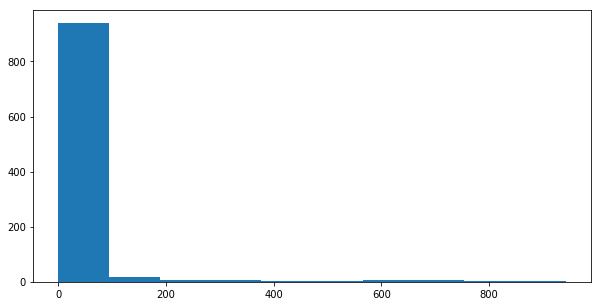

In [150]:
plt.figure(figsize=(10, 5))
plt.hist([rank for rank in ranks if rank is not None])
plt.show()

In [151]:
#average rank
sum([rank for rank in ranks if rank is not None])/ len([rank for rank in ranks if rank is not None])

24.209255533199194

In [47]:
small = []
for rank in ranks:
    if rank is not None and rank <=10:
        small.append(rank) 

In [48]:
# proportion ranked as 
len(small) / len([rank for rank in ranks if rank is not None])

0.8903420523138833

# Supervised Solution

In [189]:
training_df = pd.DataFrame()
training_df['text vectors'] = X_train_processed 
training_df['title vectors'] = y_train_processed 

In [192]:
X_test_processed= text_parser(X_test)

In [193]:
y_test_processed= text_parser(y_test)

In [194]:
test_df = pd.DataFrame()
test_df['text vectors'] = X_test_processed
test_df['title vectors'] = y_test_processed

In [195]:
training_df.shape

(178077, 2)

In [196]:
test_df.shape

(76320, 2)

In [205]:
# vectorization of the ads text
for row in range(len(training_df)):
    vector = result_vector(training_df.iloc[row, 0])
    if vector is not None:  
        training_df.iloc[row, 0] = vector[0]
    else:
        training_df.iloc[row, 0] = 'M'

In [206]:
# vectorization of the ads text
for row in range(len(test_df)):
    vector = result_vector(test_df.iloc[row, 0])
    if vector is not None:  
        test_df.iloc[row, 0] = vector[0]
    else:
        test_df.iloc[row, 0] = 'M'

In [207]:
# vectorization of the ads title
for row in range(len(training_df)):
    vector = result_vector(training_df.iloc[row, 1])
    if vector is not None:  
        training_df.iloc[row, 1] = vector[0]
    else:
        training_df.iloc[row, 1] = 'M'

In [208]:
# vectorization of the ads title
for row in range(len(test_df)):
    vector = result_vector(test_df.iloc[row, 1])
    if vector is not None:  
        test_df.iloc[row, 1] = vector[0]
    else:
        test_df.iloc[row, 1] = 'M'

In [209]:
training_df.head()

,text vectors,title vectors
538293,"[0.025280893017688714, 0.023379835297242114, -...","[0.03761335470808444, 0.036318673142796895, -0..."
109045,"[-0.01994826339063019, 0.08036307945496708, 0....","[-0.012473140246354864, 0.016946764698182137, ..."
270496,"[0.011093046484738729, 0.0741589541464377, -0....","[-0.0032796945070777957, 0.02963148260023818, ..."
698055,"[0.03191318108101999, 0.14195450896407855, -0....","[-0.06685937991765172, 0.1698023934733745, -0...."
170546,"[0.02680304303291408, 0.06821114145321708, 0.1...","[-0.005712896858679875, 0.021568166657080806, ..."


In [211]:
len(test_df.iloc[0, 0])

300

In [212]:
len(training_df.iloc[0, 0])

300

In [213]:
# remove vectors with that are comprised exclusively of the words that are missing from our vocabulary

training_df= training_df[training_df['text vectors'] != 'M']
training_df = training_df[training_df['title vectors'] != 'M']

test_df= test_df[test_df['text vectors'] != 'M']
test_df = test_df[test_df['title vectors'] != 'M']

/usr/local/lib/python3.6/site-packages/pandas/core/ops.py:1122: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x, y, op)


In [330]:
def mixed_df_creator(df):
    
    df_copy = df.copy()
    df_copy = df.reset_index(drop=True)
    
    first_half = df_copy.iloc[:int(len(df_copy)/2)]
    second_half = df_copy.iloc[int(len(df_copy)/2):]
    
    shuffled_titles = shuffle(second_half['title vectors'])
    shuffled_titles = shuffled_titles.reset_index(drop=True)
    
    second_half = second_half.reset_index(drop=True)
    second_half['title vectors'] = shuffled_titles
    
    first_half['pair class'] = 1
    second_half['pair class'] = 0
    
    concat_result = pd.concat([first_half, second_half], axis=0, ignore_index = True)
    
    return concat_result

In [331]:
training_df_mixed = mixed_df_creator(training_df)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [337]:
training_df_mixed.head()

,text vectors,title vectors,pair class
0,"[0.025280893017688714, 0.023379835297242114, -...","[0.03761335470808444, 0.036318673142796895, -0...",1
1,"[-0.01994826339063019, 0.08036307945496708, 0....","[-0.012473140246354864, 0.016946764698182137, ...",1
2,"[0.011093046484738729, 0.0741589541464377, -0....","[-0.0032796945070777957, 0.02963148260023818, ...",1
3,"[0.03191318108101999, 0.14195450896407855, -0....","[-0.06685937991765172, 0.1698023934733745, -0....",1
4,"[0.02680304303291408, 0.06821114145321708, 0.1...","[-0.005712896858679875, 0.021568166657080806, ...",1


In [338]:
training_df_mixed.tail()

,text vectors,title vectors,pair class
177180,"[0.004744647318839373, 0.08264011759448525, 0....","[0.09838836674771376, 0.05920620102100111, 0.0...",0
177181,"[-0.04871379291002143, 0.11055756048508947, 0....","[0.0007125601129498924, 0.1375821871967649, 0....",0
177182,"[0.06515243589872181, 0.13891534343771342, 0.0...","[0.10859313739423246, 0.12454978660229182, 0.0...",0
177183,"[-0.01987678013611898, 0.11034278590747913, -0...","[0.0033397121949935733, 0.010076225954675253, ...",0
177184,"[0.046849629594876596, 0.08189101589479017, 0....","[0.02786758167468277, 0.14285421610664228, 0.0...",0


In [332]:
test_df_mixed = mixed_df_creator(test_df)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [336]:
training_df_mixed.isnull().sum()

text vectors     0
title vectors    0
pair class       0
dtype: int64

In [335]:
test_df_mixed.isnull().sum()

text vectors     0
title vectors    0
pair class       0
dtype: int64

test_example = [cosine_similarity(row['text vectors'].reshape(1, -1), row['title vectors'].reshape(1, -1)) for index, row in incorrect_training[['text vectors', 'title vectors']].iloc[:int(len(training_df) / 2)].iterrows()]

In [339]:
def cosine_between_rows(row):
    sim = cosine_similarity(row['text vectors'].reshape(1, -1), row['title vectors'].reshape(1, -1))
    return sim

In [340]:
first_half_test = test_df_mixed.iloc[:int(len(test_df_mixed) / 2)]
cos_checker_test_correct = first_half_test.apply(cosine_between_rows, axis = 1)

In [341]:
np.mean(cos_checker_test_correct)

array([[0.74910414]])

In [342]:
second_half_test = test_df_mixed.iloc[int(len(test_df_mixed) / 2):]
cos_checker_test_incorrect = second_half_test.apply(cosine_between_rows, axis = 1)

In [343]:
np.mean(cos_checker_test_incorrect)

array([[0.23301563]])

In [345]:
first_half_training = training_df_mixed.iloc[:int(len(training_df_mixed) / 2)]
cos_checker_training_correct = first_half_training.apply(cosine_between_rows, axis = 1)

In [346]:
np.mean(cos_checker_training_correct)

array([[0.75797064]])

In [347]:
second_half_training = training_df_mixed.iloc[int(len(training_df_mixed) / 2):]
cos_checker_training_incorrect = second_half_training.apply(cosine_between_rows, axis = 1)

In [348]:
np.mean(cos_checker_training_incorrect)

array([[0.22930394]])

In [349]:
# for the training set
lists_training = training_df_mixed['text vectors'].apply(list) + training_df_mixed['title vectors'].apply(list)

In [350]:
lists_test = test_df_mixed['text vectors'].apply(list) + test_df_mixed['title vectors'].apply(list)

In [351]:
len(lists_training.iloc[0])

600

In [352]:
len(lists_test.iloc[0])

600

In [353]:
type(lists_training)

pandas.core.series.Series

In [354]:
new_y_training = training_df_mixed['pair class']

In [355]:
new_y_test = test_df_mixed['pair class']

In [356]:
concat_vectors_training = np.array(list(lists_training))

In [357]:
concat_vectors_test = np.array(list(lists_test))

In [358]:
concat_vectors_training.shape

(177185, 600)

In [359]:
concat_vectors_test.shape

(75803, 600)

In [360]:
rfc  =  RandomForestClassifier(
          n_jobs = -1, 
          n_estimators = 700, 
          max_depth = 6)


In [361]:
rfc.fit(concat_vectors_training, new_y_training)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [362]:
rfc.score(concat_vectors_training, new_y_training)

0.9258910178626859

In [363]:
rfc.score(concat_vectors_test, new_y_test)

0.9107159347255386

In [372]:
rfc_one  =  RandomForestClassifier(
          n_jobs = -1, 
          n_estimators = 900, 
          max_depth = 6)

In [373]:
rfc_one.fit(concat_vectors_training, new_y_training)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=900, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [374]:
rfc_one.score(concat_vectors_training, new_y_training)

0.927307616333211

In [375]:
rfc_one.score(concat_vectors_test, new_y_test)

0.9119032228275926

In [370]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_jobs = -1,
                   n_estimators = 500,
                   max_depth = 4)

In [371]:
xgb.fit(concat_vectors_training, new_y_training)

KeyboardInterrupt: 

In [ ]:
xgb.score(concat_vectors_training, new_y_training)

In [ ]:
xgb.score(concat_vectors_test, new_y_test)

In [364]:
from sklearn.linear_model import LogisticRegression

lr= LogisticRegression(C=1000)

In [365]:
lr.fit(concat_vectors_training, new_y_training)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [366]:
lr.score(concat_vectors_training, new_y_training)

0.5219459886559246

In [367]:
lr.score(concat_vectors_test, new_y_test)

0.4968800707096025

In [93]:
lasso = LogisticRegression(C=1000, penalty = 'l1')
lasso.fit(concat_vectors_training, new_y_training)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [94]:
lasso.score(concat_vectors_training, new_y_training)

0.5218669751954172

In [95]:
lasso.score(concat_vectors_test, new_y_test)

0.49772436447106316

In [98]:
training_difference = concat_training['text vectors'] - concat_training['title vectors']

In [113]:
training = np.array(list(training_difference))

In [114]:
rfc.fit(training, new_y_training)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [115]:
rfc.score(training, new_y_training)

0.6687812173716736

In [116]:
test_difference = concat_test['text vectors'] - concat_test['title vectors']
test = np.array(list(test_difference))

In [117]:
rfc.score(test, new_y_test)

0.5016819914779098

In [118]:
lr.fit(training, new_y_training)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [119]:
lr.score(training, new_y_training)

0.5142816829867088

In [120]:
lr.score(test, new_y_test)

0.5000461723150799

In [121]:
lasso.fit(training, new_y_training)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [122]:
lasso.score(training, new_y_training)

0.5142929706239241

In [123]:
lasso.score(test, new_y_test)

0.5000197881350342